In [9]:

import os
from matplotlib import pyplot as plt
import torch
import cupy as cp

In [10]:
from torchvision.io.image import read_file, decode_jpeg
os.chdir("/mnt/c/Users/smatysik/projects/nvImageCodecsWSL2/build/example/example_decode")
import nvimgcodecs
import nvcv


torch:  {'shape': (3, 720, 720), 'strides': (737280, 1024, 1), 'typestr': '=B', 'data': (35857104896, False), 'version': 2}
CodecRegistry::getCodecAndParser
Codec::getParser bmp
- probing parser:example_parser
ImageParser::canParse
example_parser_can_parse
ImageParser::canParse:0
Codec::getParser jpeg
- probing parser:nvjpeg_parser
ImageParser::canParse
jpeg_parser_can_parse
ImageParser::canParse:1
jpeg_parser_create
jpeg_create_parse_state
ImageParser::getImageInfo
jpeg_parser_get_image_info
Codec::createDecoder jpeg
- probing decoder:nvjpeg_decoder
jpeg_can_decode
jpeg_create
jpeg_create_decode_state
jpeg_decode
jpeg_destroy_decode_state
jpeg_destroy
jpeg_destroy_parse_state
jpeg_parser_destroy


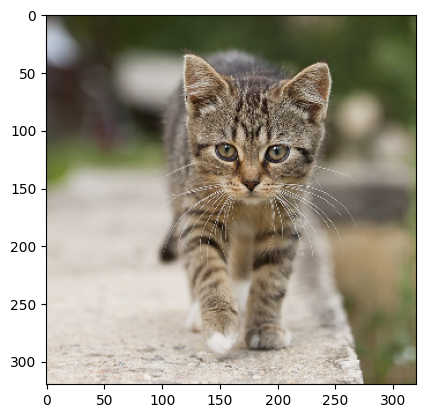

In [29]:

file_name = "tabby_tiger_cat.jpg"  # "cat_q95_444.jpg"
#data = read_file(file_name)
#inputImage = decode_jpeg(data, device="cuda")
inputImage = nvimgcodecs.imread(file_name)

#Planar (CHW) -> Interleave (NHWC)
inputImage = cp.asarray(inputImage)
inputImage = cp.moveaxis(inputImage, (0, 1, 2), (2, 0, 1))
inputImage = cp.asfortranarray(inputImage)
inputImage = cp.ascontiguousarray(inputImage)
inputImage = cp.reshape(
    inputImage, (1, inputImage.shape[0], inputImage.shape[1], inputImage.shape[2]))

nvcvInputTensor = nvcv.as_tensor(inputImage, "NHWC") 
nvcvResizeTensor = nvcvInputTensor.resize((1, 320, 320, 3), nvcv.Interp.CUBIC)

cuda_array = nvcvResizeTensor.cuda().__cuda_array_interface__ 
class cuda_array_wrapper:
    __cuda_array_interface__ = {'shape': tuple(cuda_array['shape']), 'strides': tuple(
        cuda_array['strides']), 'typestr': 'B', 'data': cuda_array['data'], 'version': 2}
a = cuda_array_wrapper()

cp_img = cp.asarray(a)
cp_img = cp.reshape(cp_img, (cp_img.shape[1], cp_img.shape[2], cp_img.shape[3]))
image = cp.asnumpy(cp_img)
plt.imshow(image)


CodecRegistry::getCodecAndParser
Codec::getParser bmp
- probing parser:example_parser
ImageParser::canParse
example_parser_can_parse
ImageParser::canParse:0
Codec::getParser jpeg
- probing parser:nvjpeg_parser
ImageParser::canParse
jpeg_parser_can_parse
ImageParser::canParse:1
jpeg_parser_create
jpeg_create_parse_state
ImageParser::getImageInfo
jpeg_parser_get_image_info
Codec::createDecoder jpeg
- probing decoder:nvjpeg_decoder
jpeg_can_decode
jpeg_create
jpeg_create_decode_state
jpeg_decode
jpeg_destroy_decode_state
jpeg_destroy
jpeg_destroy_parse_state
jpeg_parser_destroy


/home/smatysik/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/smatysik/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Class :  tiger cat  Score :  0.7251128554344177
Class :  tabby, tabby cat  Score :  0.15487384796142578
Class :  Egyptian cat  Score :  0.08538228273391724
Class :  lynx, catamount  Score :  0.02093328721821308
Class :  leopard, Panthera pardus  Score :  0.0028357314877212048


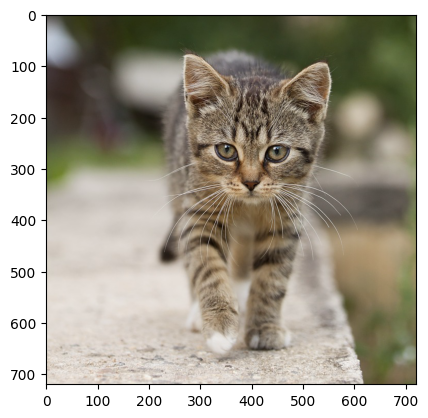

In [37]:
from torchvision import models
import numpy as np
file_name = "./tabby_tiger_cat.jpg"  # "cat_q95_444.jpg"
labelsfile = "./imagenet-classes.txt"
#data = read_file(file_name)
#inputImage = decode_jpeg(data, device="cuda")
inputImage = nvimgcodecs.imread(file_name)
imageWidth = inputImage.width
imageHeight = inputImage.height

#Planar (CHW) -> Interleave (NHWC)
inputImage = cp.asarray(inputImage)
inputImage = cp.moveaxis(inputImage, (0, 1, 2), (2, 0, 1))
inputImage = cp.asfortranarray(inputImage)
inputImage = cp.ascontiguousarray(inputImage)

image = cp.asnumpy(inputImage)
plt.imshow(image)

inputImage = cp.reshape(
    inputImage, (1, inputImage.shape[0], inputImage.shape[1], inputImage.shape[2]))

# A torch tensor/ or nvImageCodecs Image can be wrapped into a CVCUDA Object using the "as_tensor"
# function in the specified layout. The datatype and dimensions are derived
# directly from the torch tensor.
nvcvInputTensor = nvcv.as_tensor(inputImage, "NHWC") 

"""
Preprocessing includes the following sequence of operations.
Resize -> DataType Convert(U8->F32) -> Normalize(Apply mean and std deviation)
-> Interleaved to Planar
"""

# Model settings
layerHeight = 224
layerWidth = 224
batchSize = 1

# Resize
# Resize to the input network dimensions
nvcvResizeTensor = nvcvInputTensor.resize(
    (batchSize, layerHeight, layerWidth, 3), nvcv.Interp.CUBIC)
    
# Convert to the data type and range of values needed by the input layer
# i.e uint8->float. A Scale is applied to normalize the values in the range 0-1
nvcvConvertTensor = nvcvResizeTensor.convertto(np.float32, scale=1 / 255)

"""
The input to the network needs to be normalized based on the mean and
std deviation value to standardize the input data.
"""

# Create a torch tensor to store the mean and standard deviation values for R,G,B
scale = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
scaleTensor = torch.Tensor(scale)
stdTensor = torch.Tensor(std)

# Reshape the the number of channels. The R,G,B values scale and offset will be
# applied to every color plane respectively across the batch
scaleTensor = torch.reshape(scaleTensor, (1, 1, 1, 3)).cuda()
stdTensor = torch.reshape(stdTensor, (1, 1, 1, 3)).cuda()

# Wrap the torch tensor in a CVCUDA Tensor
nvcvScaleTensor = nvcv.as_tensor(scaleTensor, "NHWC")
nvcvBaseTensor = nvcv.as_tensor(stdTensor, "NHWC")

# Apply the normalize operator and indicate the scale values are std deviation
# i.e scale = 1/stddev
nvcvNormTensor = nvcvConvertTensor.normalize(
    nvcvBaseTensor, nvcvScaleTensor, nvcv.NormalizeFlags.SCALE_IS_STDDEV
)
                                                         
# The final stage in the preprocess pipeline includes converting the RGB buffer
# into a planar buffer
nvcvPreprocessedTensor = nvcvNormTensor.reformat("NCHW")   

# Inference uses pytorch to run a resnet50 model on the preprocessed input and outputs
# the classification scores for 1000 classes
# Load Resnet model pretrained on Imagenet
resnet50 = models.resnet50(pretrained=True)
resnet50.to("cuda")
resnet50.eval()

# Run inference on the preprocessed input
torchPreprocessedTensor = torch.as_tensor(nvcvPreprocessedTensor.cuda(), device="cuda")
inferOutput = resnet50(torchPreprocessedTensor)

"""
Postprocessing function normalizes the classification score from the network and sorts
the scores to get the TopN classification scores.
"""
# top results to print out
topN = 5

# Read and parse the classes
with open(labelsfile, "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Apply softmax to Normalize scores between 0-1
scores = torch.nn.functional.softmax(inferOutput, dim=1)[0]

# Sort output scores in descending order
_, indices = torch.sort(inferOutput, descending=True)

# Display Top N Results
for idx in indices[0][:topN]:
    print("Class : ", classes[idx], " Score : ", scores[idx].item())


This code below does not work as expected

torch:  {'typestr': '|u1', 'shape': (3, 640, 480), 'strides': None, 'data': (35654483968, False), 'version': 2}
cp CHW (column-major):  {'shape': (640, 480, 3), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': (1, 640, 307200), 'data': (34915483648, False)}
cp CHW (column-major):  {'shape': (640, 480, 3), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': (1, 640, 307200), 'data': (34915483648, False)}
nvcv NCHW:  {'shape': [1, 3, 640, 480], 'strides': [921600, 307200, 480, 1], 'typestr': 'B', 'data': (34921775104, False), 'version': 2}
nvcv NHWC:  {'shape': [1, 640, 480, 3], 'strides': [921600, 1440, 3, 1], 'typestr': 'B', 'data': (34928066560, False), 'version': 2}
nvcv (tuple) NHWC:  {'shape': (1, 320, 240, 3), 'strides': (235520, 736, 3, 1), 'typestr': 'B', 'data': (34917326848, False), 'version': 2}
cupy NHWC:  {'shape': (1, 320, 240, 3), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': (235

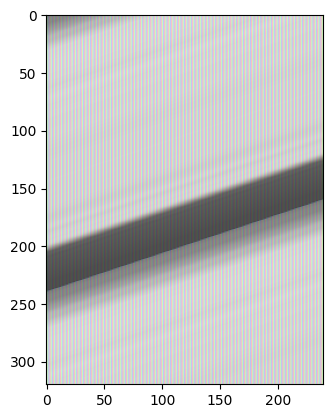

In [36]:

#data = read_file("tabby_tiger_cat.jpg")
data = read_file("cat_q95_444.jpg")
inputImage = decode_jpeg(data, device="cuda")
print("torch: ", inputImage.__cuda_array_interface__)

inputImage = cp.asarray(inputImage)
#print("torch->cp: ", inputImage.__cuda_array_interface__)
inputImage = cp.moveaxis(inputImage, (0, 1, 2), (2, 0, 1))
inputImage = cp.asfortranarray(inputImage)
print("cp CHW (column-major): ", inputImage.__cuda_array_interface__)
inputImage = cp.asfortranarray(inputImage)
print("cp CHW (column-major): ", inputImage.__cuda_array_interface__)
inputImage = cp.ascontiguousarray(inputImage)

# orignally it was "CHW" but reformat assumes for CHW column-major so interleave anyway and need to be packed pitch for dim2 ==1
nvcvInputTensor = nvcv.as_tensor(inputImage, "HWC") 
nvcvInputTensor = nvcvInputTensor.reformat("NCHW")
print("nvcv NCHW: ", nvcvInputTensor.cuda().__cuda_array_interface__)

nvcvInterleavedTensor =  nvcvInputTensor.reformat("NHWC")
print("nvcv NHWC: ", nvcvInterleavedTensor.cuda().__cuda_array_interface__)

nvcvResizeTensor = nvcvInterleavedTensor.resize((1, 320, 240, 3), nvcv.Interp.CUBIC)

cuda_array = nvcvResizeTensor.cuda().__cuda_array_interface__ 
class cuda_array_wrapper:
    __cuda_array_interface__ = {'shape': tuple(cuda_array['shape']), 'strides': tuple(
        cuda_array['strides']), 'typestr': 'B', 'data': cuda_array['data'], 'version': 2}
a = cuda_array_wrapper()
print("nvcv (tuple) NHWC: ", a.__cuda_array_interface__)

cp_img = cp.asarray(a)
print("cupy NHWC: ", cp_img.__cuda_array_interface__)
cp_img = cp.reshape(
    cp_img, (cp_img.shape[1], cp_img.shape[2], cp_img.shape[3]))
#print("cupy reshaped NHWC: ", cp_img.__cuda_array_interface__)
#cp_img = cp.asfortranarray(cp_img)
#cp_img = cp.ascontiguousarray(cp_img)
image = cp.asnumpy(cp_img)
plt.imshow(image)
